In [41]:
# airport most connected and busiest - every month, holiday season, day of the week


In [1]:
# Import all required packages

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline
sns.set()

In [2]:
# list of years and months to be used throughout the code
# data available from Jan 2017 to Jul 2018

years = ['2017', '2018']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [3]:
# initialize empty dictonary which will hold 19 cleaned dataframes, Jan 2017 to July 2018
frames = {}

# read all files using pandas
for year in years:
    if year == '2017':
        for month in months:
            path = 'Dataset_export/' + year + month + '.csv'
            df = pd.read_csv(path, low_memory=False)
            frames[year + month] = df
    else:
        for month in months[:7]: # dataset available only for first 7 months of 2018
            path = 'Dataset_export/' + year + month + '.csv'
            df = pd.read_csv(path, low_memory=False)
            frames[year + month] = df

In [26]:
def group(x):
     return pd.Series(dict(Delayed = x['DepDel15'].sum(),       # delayed flights 
                           Flights = x['Tail_Number'].count())) # total number of flights

In [27]:
# apply weight to network

def DiGraph(graph):
    
    G = nx.DiGraph()
    
    for origin, dest, data in graph.edges(data=True):
        weight = data['Flights']
        
        if G.has_edge(origin, dest):
            G[origin][dest]['weight'] += 1                    
        else:
            G.add_edge(origin, dest, weight=1)

    return G


In [28]:
# pagerank - not possible for multidigraph
# degree centrality
# betweenness centrality

def monthly_performance(G, weight=None):
    
    G_Di = DiGraph(G)
    
    page = sorted(nx.pagerank(G_Di, weight=weight).items(), key=lambda x:x[1], reverse=True)[:10]
    deg = sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True)[0:10]
    bet = sorted(nx.betweenness_centrality(G, weight=weight).items(), key=lambda x:x[1], reverse=True)[0:10]
    
    return page, deg, bet
    

In [122]:
df = {}
G_dict = {}
pagerank = {}
deg_cent = {}
bet_cent = {}

for key, value in frames.items():

    df[key] = frames[key].groupby(['Origin', 'Dest', 'FlightDate']).apply(group).reset_index()
    G_dict[key] = nx.from_pandas_edgelist(df[key], source='Origin', target='Dest', 
                                          edge_attr=['FlightDate', 'Delayed', 'Flights'], 
                                          create_using=nx.MultiDiGraph())
    
    pagerank[key], deg_cent[key], bet_cent[key] = monthly_performance(G_dict[key], weight='Flights')
    
    

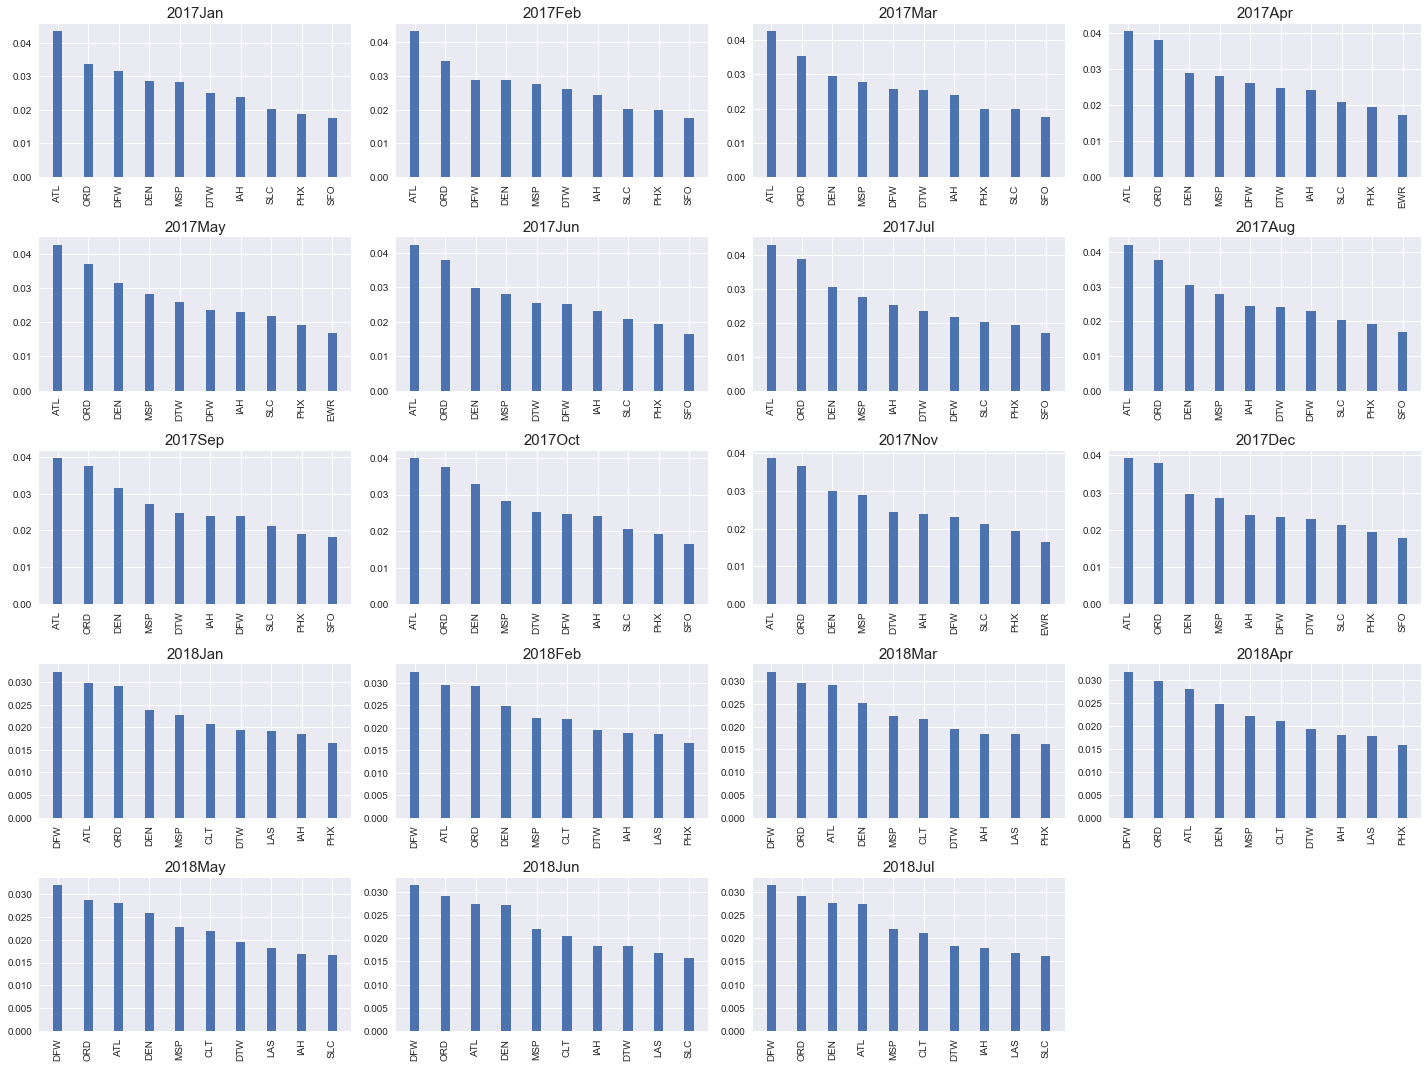

In [123]:
# plot monthly pagerank
plt.figure(figsize=(20, 15), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in pagerank.items():
    
    aiports = [x[0] for x in pagerank[key]]
    rank = [x[1] for x in pagerank[key]]
    
    ax = plt.subplot(5, 4, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()

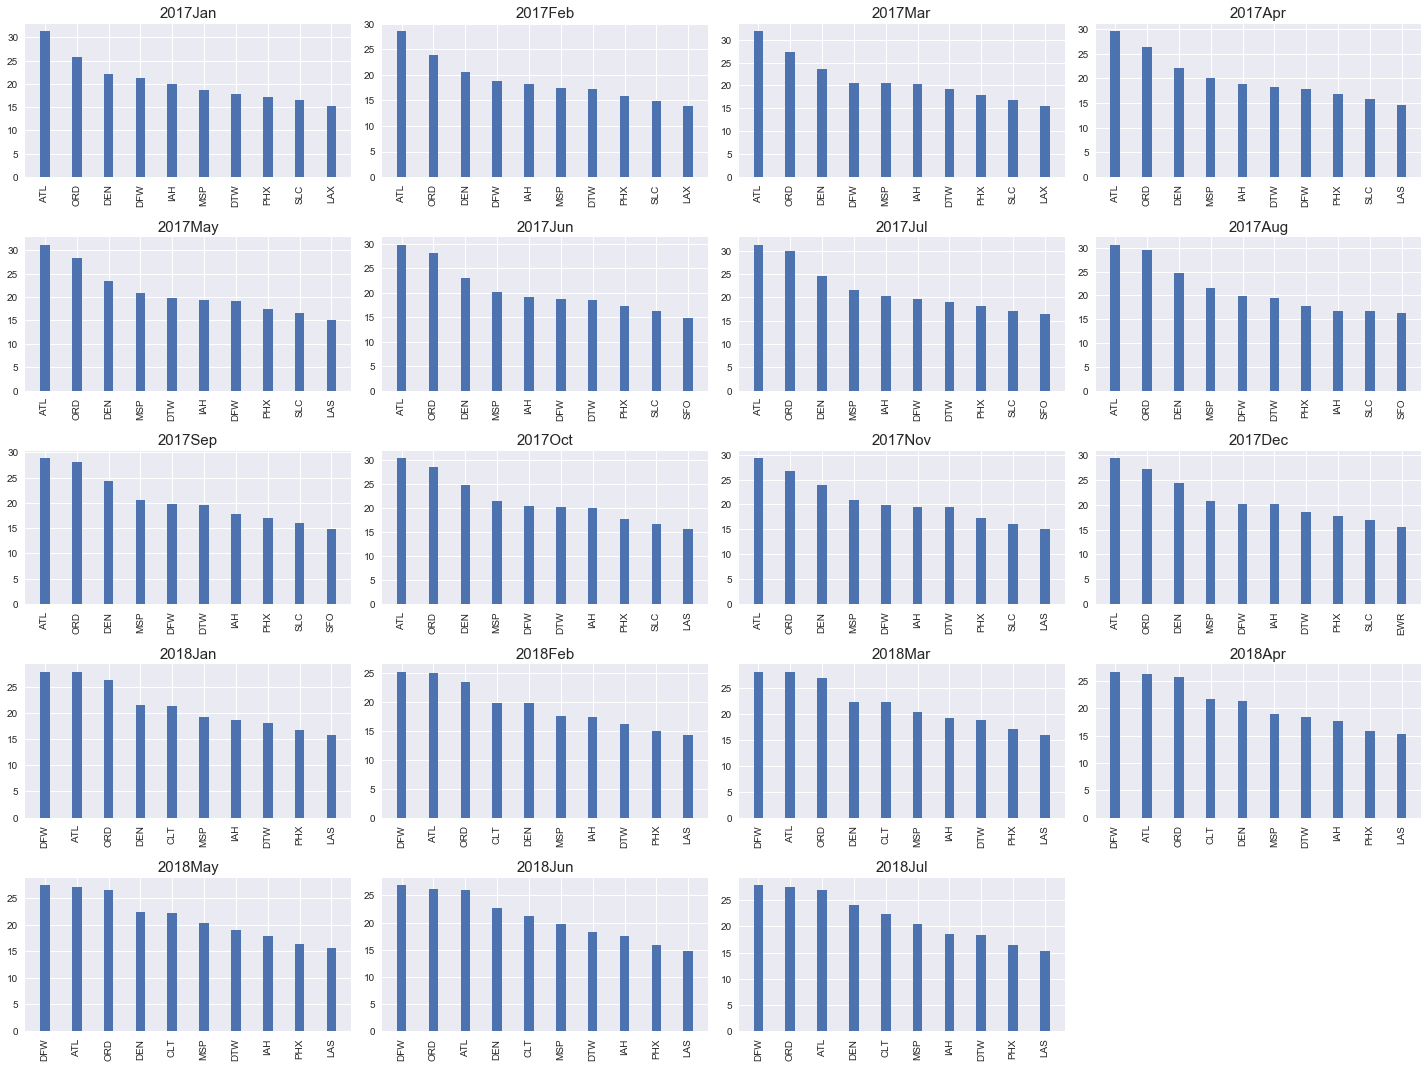

In [124]:
# plot monthly degree centrality
plt.figure(figsize=(20, 15), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in deg_cent.items():
    
    aiports = [x[0] for x in deg_cent[key]]
    rank = [x[1] for x in deg_cent[key]]
    
    ax = plt.subplot(5, 4, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()

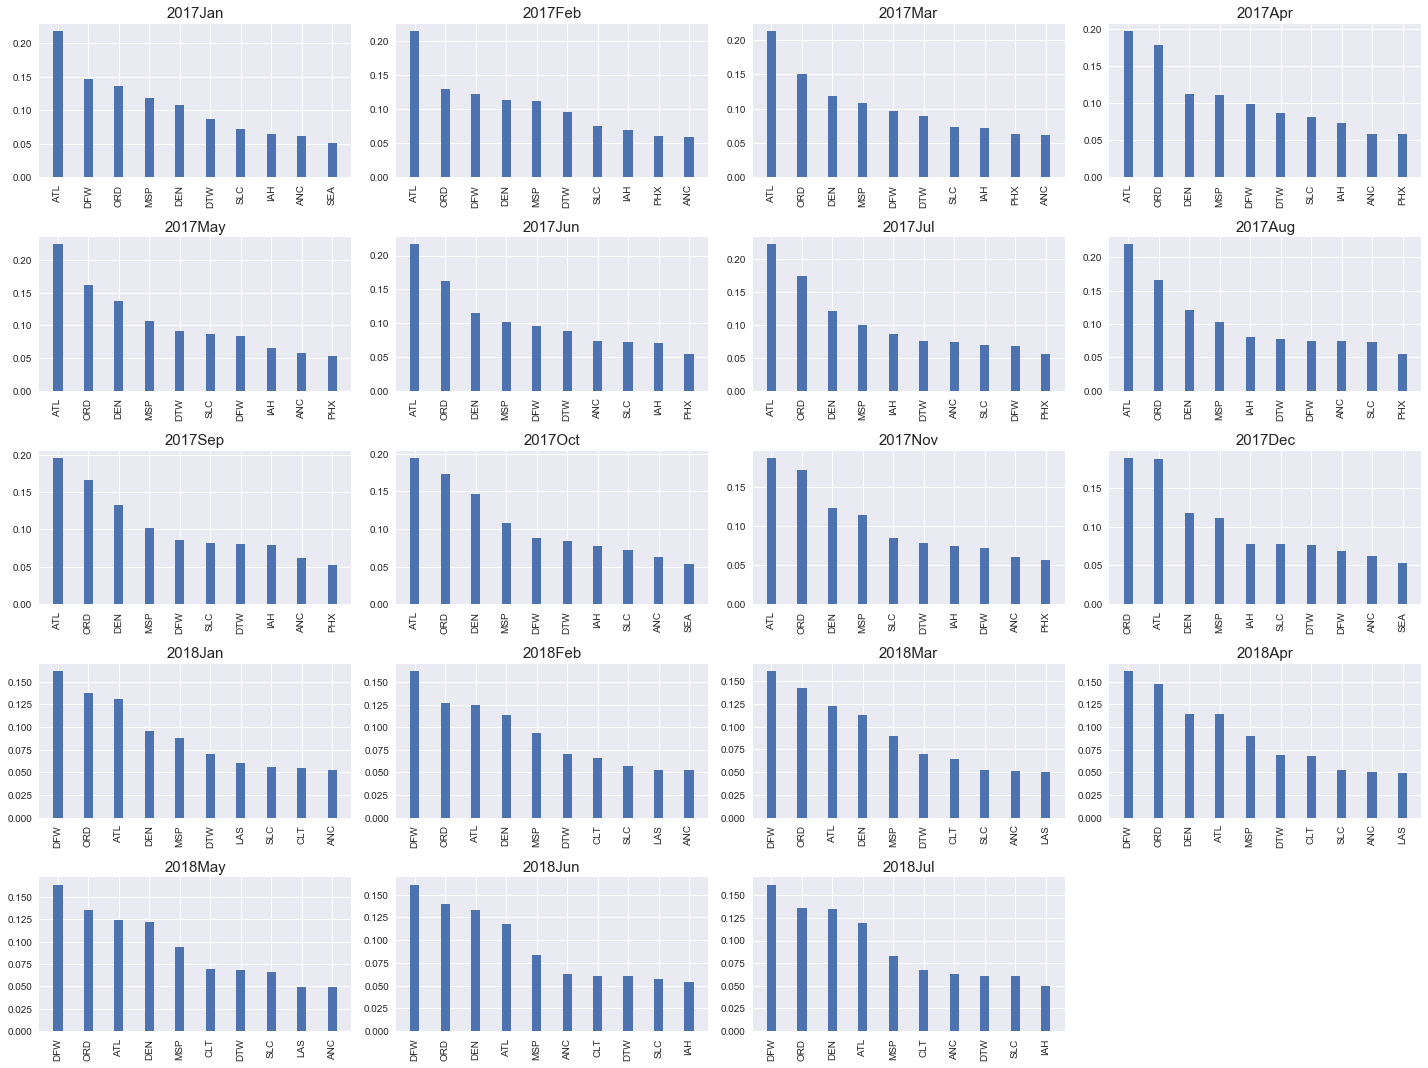

In [125]:
# plot monthly betweenness centrality
plt.figure(figsize=(20, 15), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in bet_cent.items():
    
    aiports = [x[0] for x in bet_cent[key]]
    rank = [x[1] for x in bet_cent[key]]
    
    ax = plt.subplot(5, 4, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()

In [7]:
# read holiday dataset
df_holiday = pd.read_csv(r'Dataset_export/holidays.csv')


In [21]:
df_holiday = df_holiday[(df_holiday['date of holiday'] >= '2016-12-01') & ((df_holiday['date of holiday'] <= '2018-07-31'))].sort_values('start date')

In [22]:
df_holiday['event'] = df_holiday.holiday + '_' + df_holiday.year.map(str)

In [23]:
df_holiday['date_range'] = list(zip(df_holiday['start date'], df_holiday['end date'], df_holiday['event']))

In [4]:
temp = []
for key, value in frames.items():
    temp.append(frames[key])
    frame = pd.concat(temp, ignore_index=True)


In [6]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9696548 entries, 0 to 9696547
Data columns (total 26 columns):
DayOfWeek            int64
FlightDate           object
Reporting_Airline    object
Tail_Number          object
Origin               object
Dest                 object
CRSDepTime           object
DepTime              object
DepDel15             int64
DepTimeBlk           object
TaxiOut              int64
TaxiIn               int64
CRSArrTime           object
ArrTime              object
ArrDel15             int64
ArrTimeBlk           object
Cancelled            int64
CancellationCode     int64
Diverted             int64
Distance             int64
DistanceGroup        int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(5), int64(10), object(11)
memory usage: 1.9+ GB


In [25]:
# split frame into frames_holiday dict with holiday as key

frames_holiday = {}

date_range = list(df_holiday['date_range'])

for d in date_range:
    
    temp_df = pd.DataFrame()
    #temp = []
        
    mask = ((frame.FlightDate >= d[0]) & (frame.FlightDate <= d[1]))

    #temp.append(frame.loc[mask])
    #temp_df = pd.concat(temp, ignore_index=True)
    
    temp_df = frame.loc[mask]
    
    key = d[2]
    frames_holiday[key] = temp_df      
        
        

In [26]:
frames_holiday.keys()

dict_keys(['Winter_holiday_2016', 'Presidents_day_2017', 'Easter_2017', 'Memorial_day_2017', 'Independence_day_2017', 'Labor_day_2017', 'Thanksgiving_2017', 'Winter_holiday_2017', 'Presidents_day_2018', 'Easter_2018', 'Memorial_day_2018', 'Independence_day_2018'])

In [27]:
df_h = {}
G_dict_h = {}
pagerank_h = {}
deg_cent_h = {}
bet_cent_h = {}

for key, value in frames_holiday.items():

    df_h[key] = frames_holiday[key].groupby(['Origin', 'Dest', 'FlightDate']).apply(group).reset_index()
    G_dict_h[key] = nx.from_pandas_edgelist(df_h[key], source='Origin', target='Dest', 
                                          edge_attr=['FlightDate', 'Delayed', 'Flights'], 
                                          create_using=nx.MultiDiGraph())
    
    pagerank_h[key], deg_cent_h[key], bet_cent_h[key] = monthly_performance(G_dict_h[key], weight='Flights')

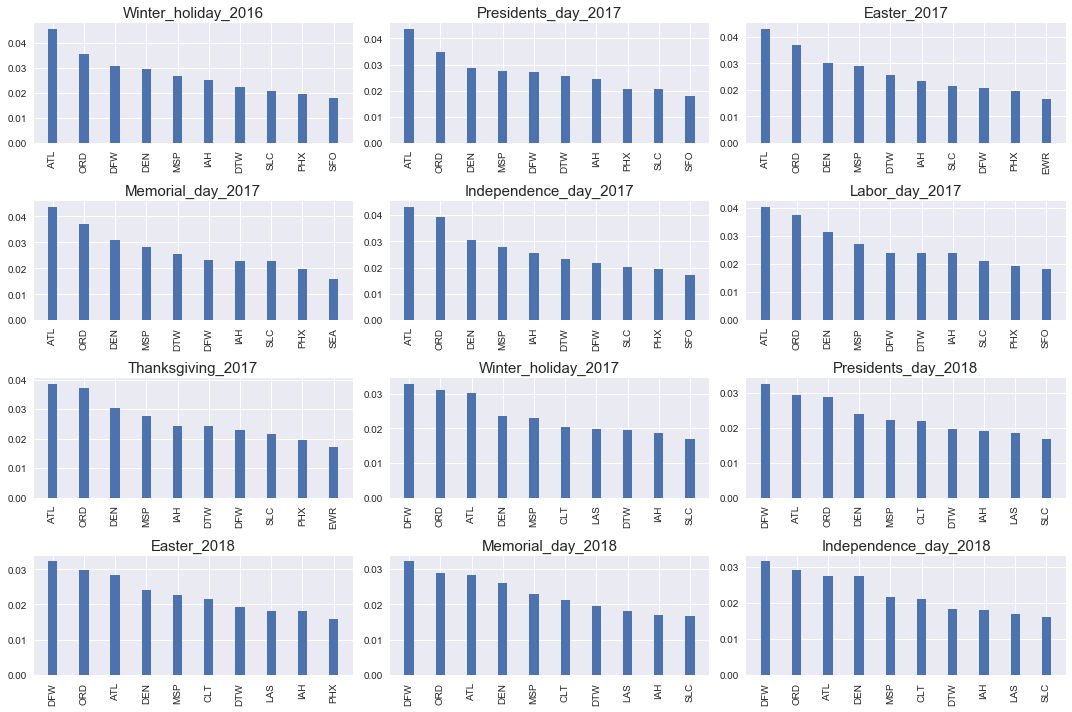

In [32]:
# plot holiday pagerank
plt.figure(figsize=(15, 10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in pagerank_h.items():
    
    aiports = [x[0] for x in pagerank_h[key]]
    rank = [x[1] for x in pagerank_h[key]]
    
    ax = plt.subplot(4, 3, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()

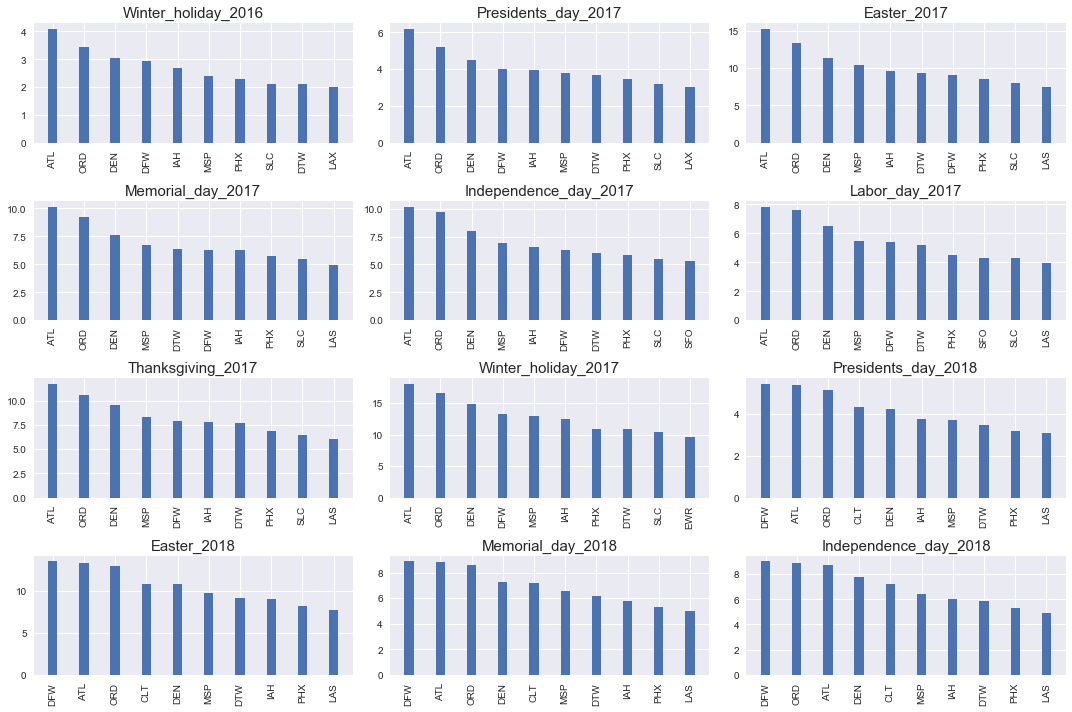

In [33]:
# plot holiday degree centrality
plt.figure(figsize=(15, 10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in deg_cent_h.items():
    
    aiports = [x[0] for x in deg_cent_h[key]]
    rank = [x[1] for x in deg_cent_h[key]]
    
    ax = plt.subplot(4, 3, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()

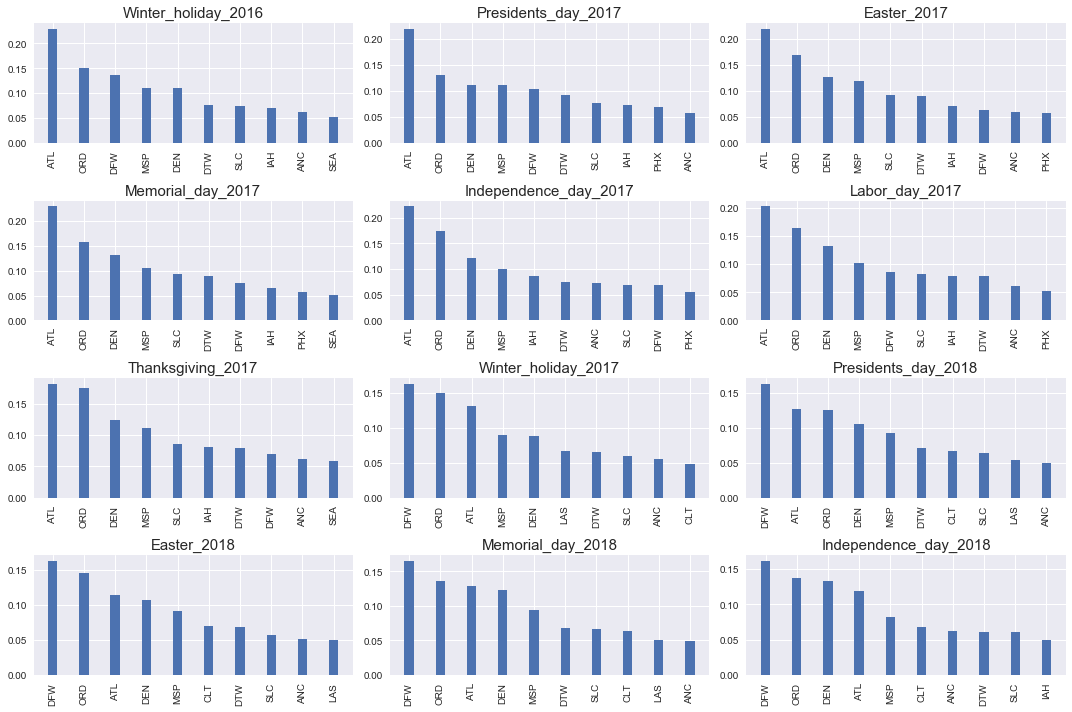

In [34]:
# plot holiday betweenness centrality
plt.figure(figsize=(15, 10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in bet_cent_h.items():
    
    aiports = [x[0] for x in bet_cent_h[key]]
    rank = [x[1] for x in bet_cent_h[key]]
    
    ax = plt.subplot(4, 3, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()

In [22]:
# split frame into frames_day dict with dow as key

frames_day = {}

days = (list(frame['DayOfWeek'].unique()))

for d in days:
    
    temp_df = pd.DataFrame()
    #temp = []
        
    mask = (frame.DayOfWeek == d)

    #temp.append(frame.loc[mask])
    #temp_df = pd.concat(temp, ignore_index=True)
    
    temp_df = frame.loc[mask]
    
    key = d
    frames_day[key] = temp_df      
        
        

In [34]:
df_day = {}
G_dict_day = {}
pagerank_day = {}
deg_cent_day = {}
bet_cent_day = {}

for key, value in frames_day.items():

    df_day[key] = frames_day[key].groupby(['Origin', 'Dest']).apply(group).reset_index()
    G_dict_day[key] = nx.from_pandas_edgelist(df_day[key], source='Origin', target='Dest', 
                                          edge_attr=['Delayed', 'Flights'], 
                                          create_using=nx.MultiDiGraph())
    
    pagerank_day[key], deg_cent_day[key], bet_cent_day[key] = monthly_performance(G_dict_day[key], weight='Flights')

In [32]:
frames_day[7]

,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Origin,Dest,CRSDepTime,DepTime,DepDel15,DepTimeBlk,...,Cancelled,CancellationCode,Diverted,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,7,2017-01-01,AA,N787AA,JFK,LAX,08:00,08:31,1,0800-0859,...,0,0,0,2475,10,27.0,0.0,0.0,0.0,0.0
7,7,2017-01-08,AA,N790AA,JFK,LAX,08:00,08:04,0,0800-0859,...,0,0,0,2475,10,0.0,4.0,17.0,0.0,0.0
13,7,2017-01-15,AA,N794AA,JFK,LAX,08:00,07:58,0,0800-0859,...,0,0,0,2475,10,0.0,0.0,23.0,0.0,0.0
19,7,2017-01-22,AA,N793AA,JFK,LAX,08:00,08:47,1,0800-0859,...,0,0,0,2475,10,0.0,0.0,53.0,0.0,0.0
25,7,2017-01-29,AA,N790AA,JFK,LAX,08:00,07:55,0,0800-0859,...,0,0,0,2475,10,0.0,0.0,0.0,0.0,0.0
28,7,2017-01-01,AA,N783AA,LAX,JFK,09:00,09:34,1,0900-0959,...,0,0,0,2475,10,34.0,0.0,8.0,0.0,0.0
34,7,2017-01-08,AA,N797AA,LAX,JFK,09:00,08:55,0,0900-0959,...,0,0,0,2475,10,0.0,0.0,0.0,0.0,0.0
41,7,2017-01-15,AA,N783AA,LAX,JFK,09:00,10:58,1,0900-0959,...,0,0,0,2475,10,83.0,0.0,0.0,0.0,0.0
48,7,2017-01-22,AA,N797AA,LAX,JFK,09:00,08:54,0,0900-0959,...,0,0,0,2475,10,0.0,0.0,0.0,0.0,0.0
55,7,2017-01-29,AA,N783AA,LAX,JFK,09:00,08:53,0,0900-0959,...,0,0,0,2475,10,0.0,0.0,0.0,0.0,0.0


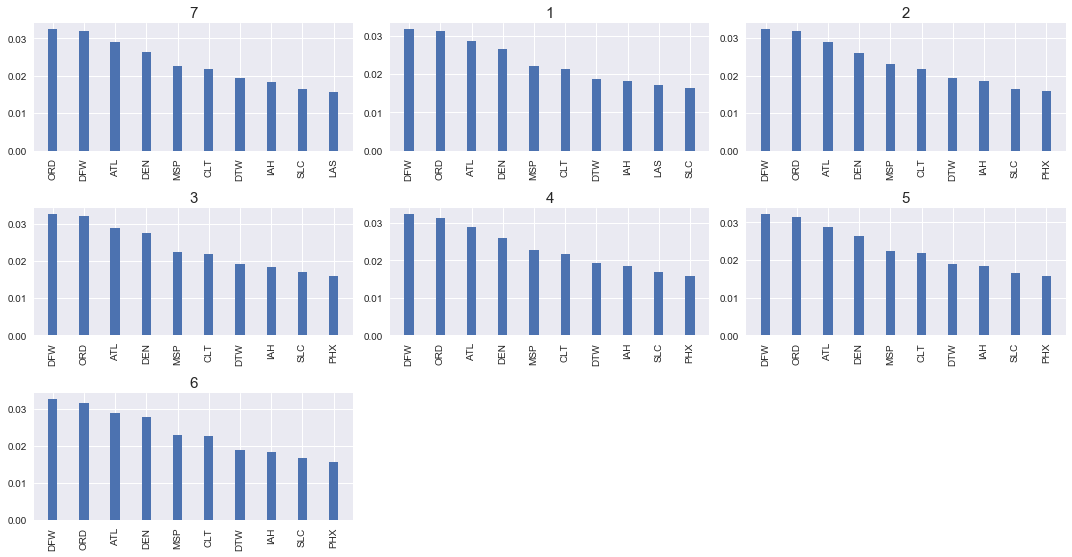

In [36]:
# plot dow pagerank
plt.figure(figsize=(15, 10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in pagerank_day.items():
    
    aiports = [x[0] for x in pagerank_day[key]]
    rank = [x[1] for x in pagerank_day[key]]
    
    ax = plt.subplot(4, 3, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()

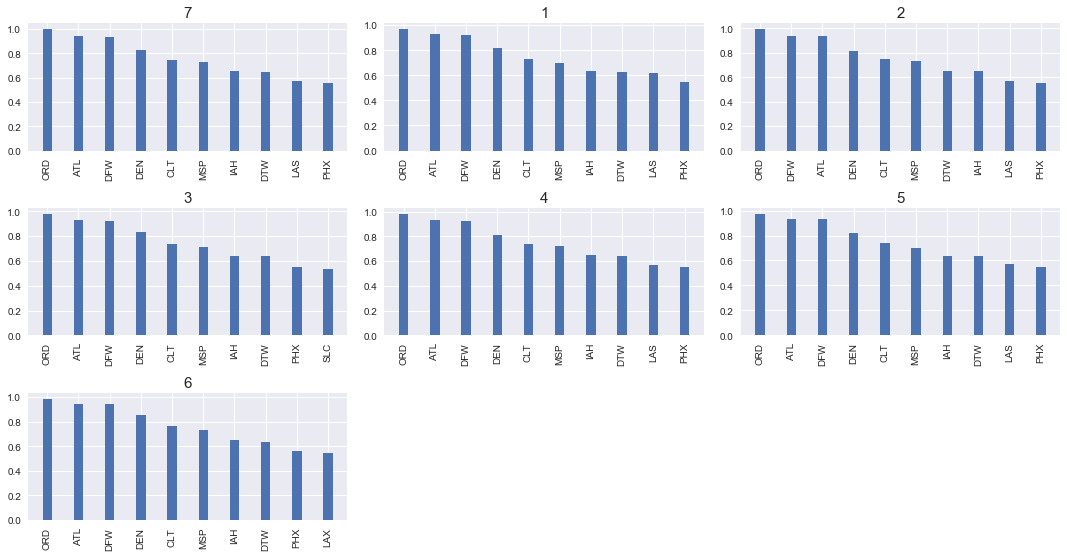

In [37]:
# plot dow degree centrality
plt.figure(figsize=(15, 10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in deg_cent_day.items():
    
    aiports = [x[0] for x in deg_cent_day[key]]
    rank = [x[1] for x in deg_cent_day[key]]
    
    ax = plt.subplot(4, 3, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()

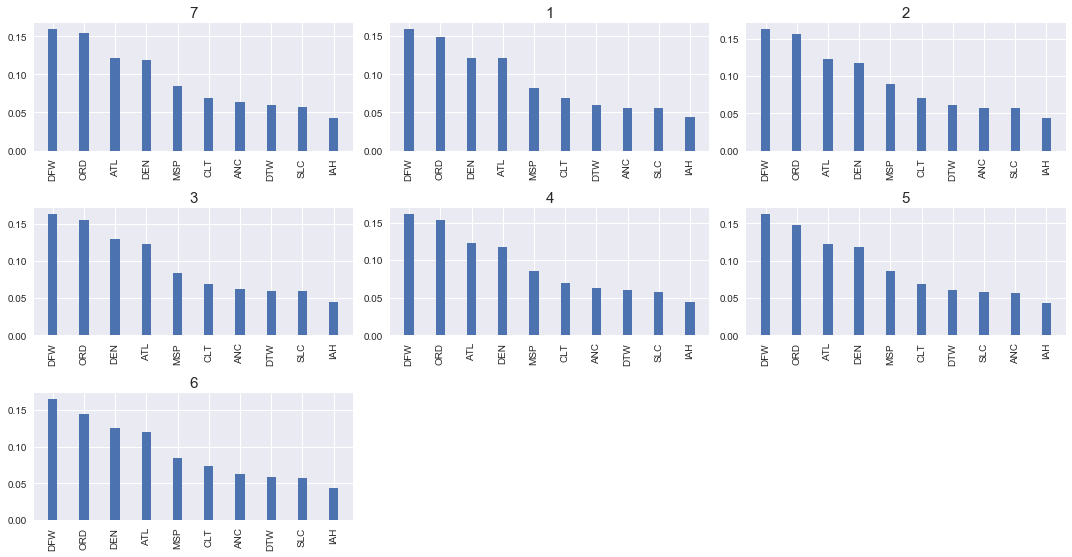

In [38]:
# plot dow betweenness centrality
plt.figure(figsize=(15, 10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1

for key, value in bet_cent_day.items():
    
    aiports = [x[0] for x in bet_cent_day[key]]
    rank = [x[1] for x in bet_cent_day[key]]
    
    ax = plt.subplot(4, 3, plot_number)
    ax.bar(aiports, rank, width=0.3)
    
    ax.set_title(key, fontdict={'fontsize': 15})
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(rotation=90)
    
    
    plot_number = plot_number + 1

plt.tight_layout()